In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Menyiapkan Direktor

In [ ]:
%cd /content/drive/MyDrive/model/

/content/drive/MyDrive/model


In [ ]:
base_dir = '/content/drive/MyDrive/model/'
!ls "/content/drive/MyDrive/model/"

bahan  fres1.jpg  latih  model.h5  validasi


In [ ]:
bahan_dir = os.path.join(base_dir,'bahan')
train_dir = os.path.join(base_dir,'latih')
validation_dir = os.path.join(base_dir,'validasi')

In [ ]:
murni_dir = os.path.join(bahan_dir, 'murni/')
campuran_dir = os.path.join(bahan_dir,'campuran/')

print("Jumlah Data Train Tiap Kelas")
print('Jumlah gambar daging sapi murni:', len(os.listdir(murni_dir)))
print('Jumlah gambar daging sapi campuran:', len(os.listdir(campuran_dir)))


Jumlah Data Train Tiap Kelas
Jumlah gambar daging sapi murni: 250
Jumlah gambar daging sapi campuran: 250


In [ ]:
train_murni = os.path.join(train_dir, 'murni/')
train_campuran = os.path.join(train_dir, 'campuran/')

validation_murni = os.path.join(validation_dir, 'murni/')
validation_campuran = os.path.join(validation_dir, 'campuran/')

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

train_ratio = 0.9

source_00 = murni_dir
train_00 = train_murni
val_00 = validation_murni
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = campuran_dir
train_01 = train_campuran
val_01 = validation_campuran
train_val_split(source_01, train_01, val_01, train_ratio)


In [ ]:
print('Jumlah All Status :', len(os.listdir(campuran_dir)))
print('Jumlah Train Fresh :', len(os.listdir(train_campuran)))
print('Jumlah Val Fresh :', len(os.listdir(validation_campuran)))

Jumlah All Status : 250
Jumlah Train Fresh : 225
Jumlah Val Fresh : 25


Pre Processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale = 1./255,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                  rescale = 1./255,
                  rotation_range = 30,
                  horizontal_flip = True,
                  shear_range = 0.3,
                  fill_mode = 'nearest',
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  zoom_range = 0.1
)

Target

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 450 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.95):
      print('\nAkurasi mencapai 95%')
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [ ]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16,(3, 3), activation = 'relu', input_shape = (150, 150, 3)),
          tf.keras.layers.MaxPool2D(2, 2),
          tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPool2D(3, 3),
          tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
          tf.keras.layers.MaxPooling2D(2, 2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(200, activation = 'relu'),
          tf.keras.layers.Dropout(0.3, seed=112),
          tf.keras.layers.Dense(500, activation = 'relu'),
          tf.keras.layers.Dropout(0.5, seed=112),
          tf.keras.layers.Dense(2, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 64)       0

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch= 6,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/20
6/6 [==============================] - 8s 1s/step - loss: 0.7251 - accuracy: 0.6167 - val_loss: 0.7191 - val_accuracy: 0.4000
Epoch 2/20
6/6 [==============================] - 5s 846ms/step - loss: 0.7360 - accuracy: 0.4333 - val_loss: 0.7098 - val_accuracy: 0.5000
Epoch 3/20
6/6 [==============================] - 6s 1s/step - loss: 0.6893 - accuracy: 0.5167 - val_loss: 0.7297 - val_accuracy: 0.4000
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.6848 - val_accuracy: 0.6000
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.6709 - accuracy: 0.5667 - val_loss: 0.7202 - val_accuracy: 0.5000
Epoch 6/20
6/6 [==============================] - 5s 790ms/step - loss: 0.6813 - accuracy: 0.5333 - val_loss: 0.6977 - val_accuracy: 0.4000
Epoch 7/20
6/6 [==============================] - 7s 1s/step - loss: 0.6706 - accuracy: 0.6667 - val_loss: 0.6397 - val_accuracy: 0.9000
Epoch 8/20
6/6 [===================

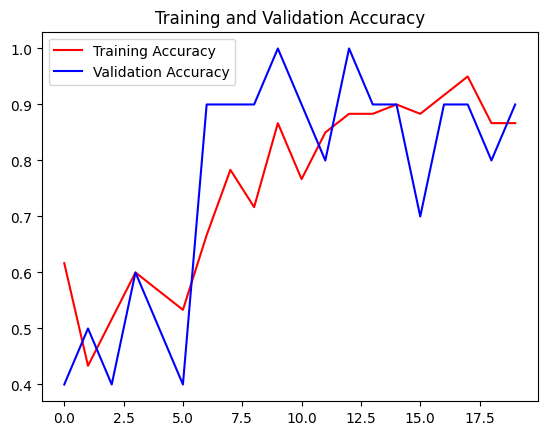

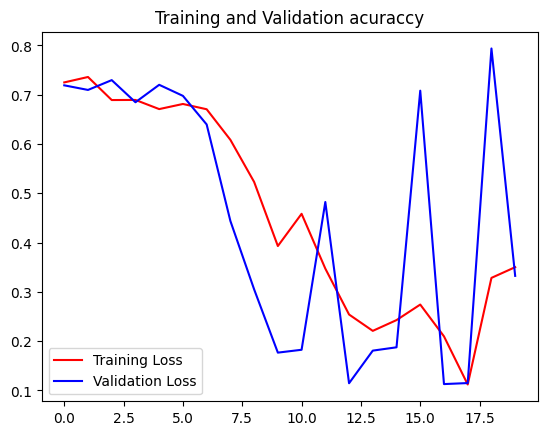

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation acuraccy')
plt.legend(loc='best')
plt.show()

Saving WIN_20220623_12_07_51_Pro.jpg to WIN_20220623_12_07_51_Pro.jpg
1/1 [==============================] - 0s 49ms/step
Rentang hasil prediksi:
Nilai Minimum: 0.0
Nilai Maksimum: 1.0
WIN_20220623_12_07_51_Pro.jpg
This Image belongs to class campuran


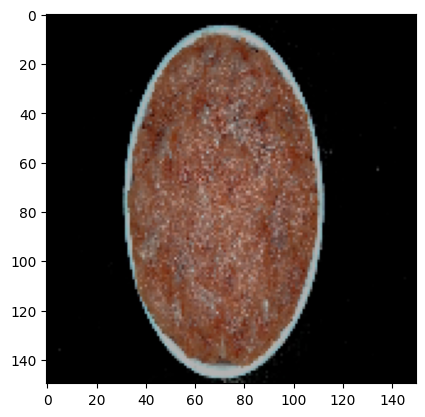

In [ ]:
import numpy as np
import keras.utils as image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)
  nilai_min = np.min(classes)
  nilai_max = np.max(classes)

  print("Rentang hasil prediksi:")
  print("Nilai Minimum:", nilai_min)
  print("Nilai Maksimum:", nilai_max)


  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] == 1 :
      print('This Image belongs to class', class_list[j])
      break

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/saved models/subscribe_murnicampuran.h5')

NameError: ignored